# **Test - Quant Researcher**

## 📉 **Challenge**

### **“The Sun and the Market”**

A debated hypothesis in the behavioral finance literature posits that solar activity (sunspots / geomagnetic storms) may affect human mood and thereby influence aggregate risk preferences reflected in asset prices.

Your objective is to test this hypothesis using a quantitative empirical approach.

### **1. Data Collection**

- **Market series:** obtain **daily** S&P 500 data over the **past 20 years** (via yfinance or an equivalent data source).
    - The Yahoo Finance symbol commonly used is **^GSPC**.
- **Exogenous series:** obtain **monthly** **Sunspot Numbers (SN)** from a citable, reputable source (e.g., **SIDC / SILSO**).

### **2. Empirical Exercise**

- **Data alignment:** reconcile daily and monthly frequencies with explicit attention to **timing conventions** and **look-ahead bias**.
    - At minimum, SN observed for month *M* must only be used with a **lag** for returns from *M+1* onward.
- **Estimation:** implement a simple predictive specification (e.g., correlation, OLS regression, or an alternative baseline) assessing whether SN contains incremental information about S&P 500 returns.
- **Inference:** report appropriate statistical diagnostics (e.g., standard errors, t-statistics, p-values) and any robustness checks supporting the conclusion.

### **3. Investment Conclusion**

Based strictly on your empirical results: **would you allocate capital to this signal at Wise Capital?** Provide a quantitative justification and discuss limitations.

## **1. Data Collection**

### **Imports statements**

In [35]:
import requests
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

### **Download S&P data**

To proceed to this brief analysis it is going to be used the S&P500 index to verify if there is a correlation between the macro returns from the american stocks and solar activity.

The S&P500 data will be downloaded from the yahoo finance database.

In [36]:
# Set the S&P500 ticker
ticker = '^GSPC'

# Download the S&P500 data from the last 20 years (approximately, for reproducebility)
sp500_data = yf.download(ticker, start='2004-12-31', end='2025-12-16', interval='1d', auto_adjust=False)

# Print the first five rows
print()
print(sp500_data.head())

[*********************100%***********************]  1 of 1 completed


Price         Adj Close        Close         High          Low         Open  \
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC        ^GSPC   
Date                                                                          
2004-12-31  1211.920044  1211.920044  1217.329956  1211.650024  1213.550049   
2005-01-03  1202.079956  1202.079956  1217.800049  1200.319946  1211.920044   
2005-01-04  1188.050049  1188.050049  1205.839966  1185.390015  1202.079956   
2005-01-05  1183.739990  1183.739990  1192.729980  1183.719971  1188.050049   
2005-01-06  1187.890015  1187.890015  1191.630005  1183.270020  1183.739990   

Price           Volume  
Ticker           ^GSPC  
Date                    
2004-12-31   786900000  
2005-01-03  1510800000  
2005-01-04  1721000000  
2005-01-05  1738900000  
2005-01-06  1569100000  


### **Cleaning S&P500 data and feature engineering**

In [37]:
# Print S&P500 summary information
print('S&P500 DataFrame information:')
print(sp500_data.info())
print()

# Print S&P500 describing statatistics
print('Describing statistics:')
print(sp500_data.describe())

# Check is there is any na
print()
print("Checking na's:")
print(sp500_data.isna().sum())


S&P500 DataFrame information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5273 entries, 2004-12-31 to 2025-12-15
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, ^GSPC)  5273 non-null   float64
 1   (Close, ^GSPC)      5273 non-null   float64
 2   (High, ^GSPC)       5273 non-null   float64
 3   (Low, ^GSPC)        5273 non-null   float64
 4   (Open, ^GSPC)       5273 non-null   float64
 5   (Volume, ^GSPC)     5273 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 288.4 KB
None

Describing statistics:
Price     Adj Close        Close         High          Low         Open  \
Ticker        ^GSPC        ^GSPC        ^GSPC        ^GSPC        ^GSPC   
count   5273.000000  5273.000000  5273.000000  5273.000000  5273.000000   
mean    2527.594957  2527.594957  2541.067976  2512.169438  2527.128610   
std     1483.617841  1483.617841  1490.447396  1475.678996  1483.389350  

Creating the feature daily_change, which shows the daily price change. To simplify this task, the multi-index column will be replaced by a simple column index. Also, Yahoo Finance provides the data with the date as the index. The date will become a feature, and the index will be reset to integers.

In [38]:
# Simplifying column index
sp500_data.columns = sp500_data.columns.get_level_values(0)

# Simplifying row index
sp500_data['date'] = sp500_data.index
sp500_data.reset_index(drop=True, inplace=True)

# Print the new structure
print(sp500_data.head())
print()
print(sp500_data.info())

Price    Adj Close        Close         High          Low         Open  \
0      1211.920044  1211.920044  1217.329956  1211.650024  1213.550049   
1      1202.079956  1202.079956  1217.800049  1200.319946  1211.920044   
2      1188.050049  1188.050049  1205.839966  1185.390015  1202.079956   
3      1183.739990  1183.739990  1192.729980  1183.719971  1188.050049   
4      1187.890015  1187.890015  1191.630005  1183.270020  1183.739990   

Price      Volume       date  
0       786900000 2004-12-31  
1      1510800000 2005-01-03  
2      1721000000 2005-01-04  
3      1738900000 2005-01-05  
4      1569100000 2005-01-06  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5273 entries, 0 to 5272
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Adj Close  5273 non-null   float64       
 1   Close      5273 non-null   float64       
 2   High       5273 non-null   float64       
 3   Low        5273 non-nu

In [39]:
# Filter only the relevant columns
sp500_data = sp500_data[['date','Adj Close']]

# Print the new structure
print(sp500_data.tail())
print()
print(sp500_data.info())

Price       date    Adj Close
5268  2025-12-09  6840.509766
5269  2025-12-10  6886.680176
5270  2025-12-11  6901.000000
5271  2025-12-12  6827.410156
5272  2025-12-15  6816.509766

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5273 entries, 0 to 5272
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       5273 non-null   datetime64[ns]
 1   Adj Close  5273 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 82.5 KB
None


In [40]:
# Get the last data of every month
df_sp500 = sp500_data[['date','Adj Close']].resample('M', on='date').last()
df_sp500.reset_index(drop=False, inplace=True)
print(df_sp500.head())

Price       date    Adj Close
0     2004-12-31  1211.920044
1     2005-01-31  1181.270020
2     2005-02-28  1203.599976
3     2005-03-31  1180.589966
4     2005-04-30  1156.849976


/tmp/ipython-input-3683391080.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_sp500 = sp500_data[['date','Adj Close']].resample('M', on='date').last()


In [41]:
# Create a multiindex using the year and the month
df_sp500.index = [df_sp500['date'].dt.year, df_sp500['date'].dt.month]
df_sp500.index.names = ['year','month']
df_sp500.drop(columns=['date'], inplace=True)
print(df_sp500.head(20))

Price         Adj Close
year month             
2004 12     1211.920044
2005 1      1181.270020
     2      1203.599976
     3      1180.589966
     4      1156.849976
     5      1191.500000
     6      1191.329956
     7      1234.180054
     8      1220.329956
     9      1228.810059
     10     1207.010010
     11     1249.479980
     12     1248.290039
2006 1      1280.079956
     2      1280.660034
     3      1294.869995
     4      1310.609985
     5      1270.089966
     6      1270.199951
     7      1276.660034


In [42]:
df_sp500['monthly_change'] = df_sp500['Adj Close'].pct_change().fillna(0)

print(df_sp500.head(20))

Price         Adj Close  monthly_change
year month                             
2004 12     1211.920044        0.000000
2005 1      1181.270020       -0.025290
     2      1203.599976        0.018903
     3      1180.589966       -0.019118
     4      1156.849976       -0.020109
     5      1191.500000        0.029952
     6      1191.329956       -0.000143
     7      1234.180054        0.035968
     8      1220.329956       -0.011222
     9      1228.810059        0.006949
     10     1207.010010       -0.017741
     11     1249.479980        0.035186
     12     1248.290039       -0.000952
2006 1      1280.079956        0.025467
     2      1280.660034        0.000453
     3      1294.869995        0.011096
     4      1310.609985        0.012156
     5      1270.089966       -0.030917
     6      1270.199951        0.000087
     7      1276.660034        0.005086


### **Download SILSO data**

As the official SILSO documentation states$^1$, the data has these columns:
- Column 1-2: Gregorian calendar date
  - Year
  - Month
- Column 3: Date in fraction of year.
- Column 4: Monthly mean total sunspot number.
- Column 5: Monthly mean standard deviation of the input sunspot numbers.
- Column 6: Number of observations used to compute the monthly mean total sunspot number.
- Column 7: Definitive/provisional marker. '1' indicates that the value is definitive. '0' indicates that the value is still provisional.

$^1$ https://www.sidc.be/SILSO/infosnmtot

In [43]:
# Set the official url for download the data
url = 'https://www.sidc.be/silso/DATA/SN_m_tot_V2.0.csv'

# Make the request
response = requests.get(url)

# Raise an error, on error
response.raise_for_status()

# Save the file
with open('SN_m_tot_V2.0.csv', 'wb') as f:
    f.write(response.content)

# Create a Pandas DataFrame
silso_data = pd.read_csv('SN_m_tot_V2.0.csv', sep=';', header = None, names=['year','month','date_frac_year','monthly_sn','monthly_std','n_obs','prov_indicator'])

print(silso_data.tail())
print()
print(silso_data.info())

      year  month  date_frac_year  monthly_sn  monthly_std  n_obs  \
3318  2025      7        2025.538       125.6         16.9   1145   
3319  2025      8        2025.623       133.5         18.2   1114   
3320  2025      9        2025.705       129.8         15.4    961   
3321  2025     10        2025.790       114.6         17.5    827   
3322  2025     11        2025.873        91.8         13.9    792   

      prov_indicator  
3318               0  
3319               0  
3320               0  
3321               0  
3322               0  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            3323 non-null   int64  
 1   month           3323 non-null   int64  
 2   date_frac_year  3323 non-null   float64
 3   monthly_sn      3323 non-null   float64
 4   monthly_std     3323 non-null   float64
 5   n_obs           3323

### **Cleaning SILSO data and feature engineering**

In [44]:
# Filter only the relevant columns
df_silso = silso_data[['year','month','monthly_sn']]

# Create a multiindex using the year and the month
df_silso.index = [df_silso['year'], df_silso['month']]
df_silso.drop(columns=['year','month'], inplace=True)



/tmp/ipython-input-3624126399.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_silso.drop(columns=['year','month'], inplace=True)


In [45]:
# Print some data
print(df_silso.tail())

# Print the DataFrame info
print()
print(df_silso.info())

#Checking for NAs
print()
print(df_silso.isna().sum())
print()
print(df_silso.head())

            monthly_sn
year month            
2025 7           125.6
     8           133.5
     9           129.8
     10          114.6
     11           91.8

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3323 entries, (np.int64(1749), np.int64(1)) to (np.int64(2025), np.int64(11))
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   monthly_sn  3323 non-null   float64
dtypes: float64(1)
memory usage: 46.4 KB
None

monthly_sn    0
dtype: int64

            monthly_sn
year month            
1749 1            96.7
     2           104.3
     3           116.7
     4            92.8
     5           141.7


## **2. Empirical Exercise**

### **Data Alignment**

#### **Merging both the DataFrames**

As we must not assume that the Sunspot Number (SN) of month M is only known in month M + 1, we must shift the SILSO DataFrame index so that the SN observed for month M is only used with a lag for returns from M + 1 onward.

In [46]:
df_silso_lag = df_silso.shift(1)
df_silso_lag.columns = ['monthly_sn_lag']

In [47]:
print(df_silso.head())
print()
print(df_silso_lag.head())



            monthly_sn
year month            
1749 1            96.7
     2           104.3
     3           116.7
     4            92.8
     5           141.7

            monthly_sn_lag
year month                
1749 1                 NaN
     2                96.7
     3               104.3
     4               116.7
     5                92.8


As the datatypes and the DataFrame structures are fine, they will be merged.

In [48]:
# Merge DataFrames
df = df_sp500.merge(df_silso_lag, how='inner', left_index=True, right_index=True)
print(df.head())
print()
print(df.tail())

              Adj Close  monthly_change  monthly_sn_lag
year month                                             
2004 12     1211.920044        0.000000            70.1
2005 1      1181.270020       -0.025290            28.9
     2      1203.599976        0.018903            48.1
     3      1180.589966       -0.019118            43.5
     4      1156.849976       -0.020109            39.6

              Adj Close  monthly_change  monthly_sn_lag
year month                                             
2025 7      6339.390137        0.021667           114.6
     8      6460.259766        0.019066           125.6
     9      6688.459961        0.035324           133.5
     10     6840.200195        0.022687           129.8
     11     6849.089844        0.001300           114.6


The first `monthly_change` is actually invalid data, since there is no data from the previous month due to the time cut. The column `Adj Close` will be removed.

In [49]:
df = df.drop(index=df.index[0])
df = df.drop(columns=['Adj Close'])
print(df.head())

            monthly_change  monthly_sn_lag
year month                                
2005 1           -0.025290            28.9
     2            0.018903            48.1
     3           -0.019118            43.5
     4           -0.020109            39.6
     5            0.029952            38.7


#### **Exploring data**

First of all, the descriptive statistics of the final DataFrame will be shown.

In [50]:
print(df.describe())

       monthly_change  monthly_sn_lag
count      251.000000      251.000000
mean         0.007851       54.513944
std          0.042877       48.906143
min         -0.169425        0.000000
25%         -0.016455       10.400000
50%          0.012864       37.400000
75%          0.034111       93.350000
max          0.126844      216.000000


Although we apparently had no missing data in the SN column, a value of 0.000000 is probably a missing value. Let’s check whether there is a large number of zeros in the DataFrame.

In [51]:
print((df['monthly_sn_lag'] == 0).sum())

1


As we got only one, it may be a valid value. Even if it is not, it will not bias our analysis.

Next, we are going to see the data distribution.

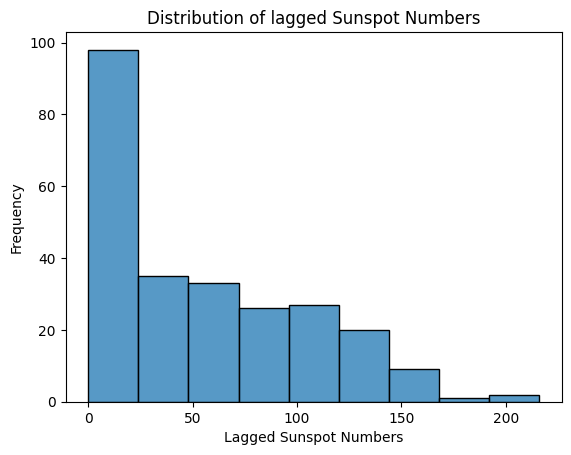

In [52]:
sns.histplot(data=df, x='monthly_sn_lag')
plt.title('Distribution of lagged Sunspot Numbers')
plt.xlabel('Lagged Sunspot Numbers')
plt.ylabel('Frequency')
plt.show()

We can observe a right-skewed distribution, with a large concentration of values near zero and a long right tail.

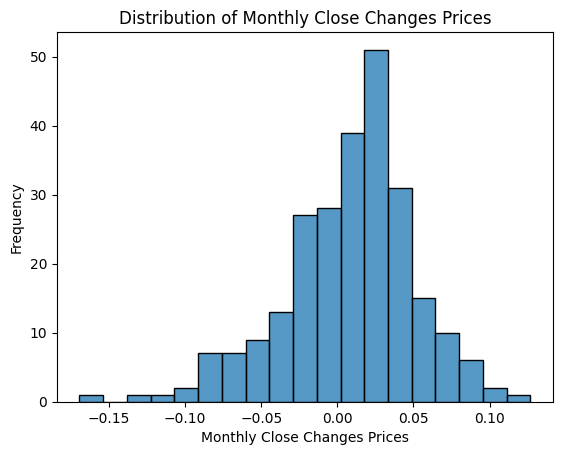

In [53]:
sns.histplot(data=df, x='monthly_change')
plt.title('Distribution of Monthly Close Changes Prices')
plt.xlabel('Monthly Close Changes Prices')
plt.ylabel('Frequency')
plt.show()

Here we observe an approximately symmetric, bell-shaped distribution.



Now, let's visualize the boxplots to see the profile of our data (and also check for outliers).

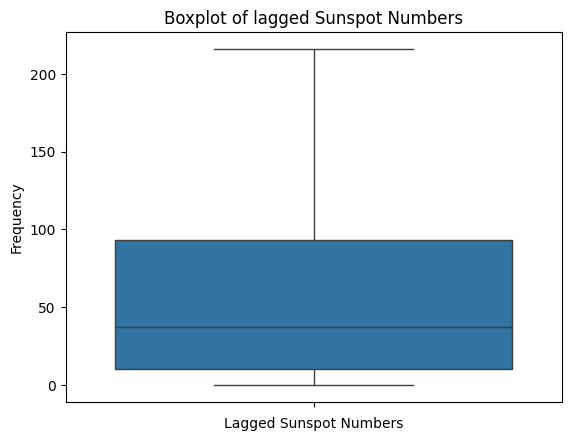

In [54]:
sns.boxplot(data=df, y='monthly_sn_lag')
plt.title('Boxplot of lagged Sunspot Numbers')
plt.xlabel('Lagged Sunspot Numbers')
plt.ylabel('Frequency')
plt.show()

There is no evidence of outliers in the SN column.

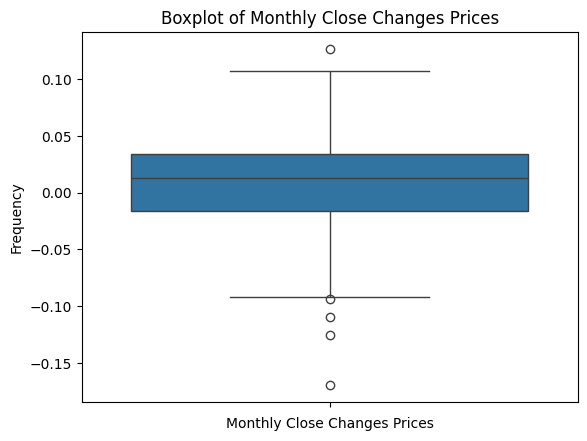

In [55]:
sns.boxplot(data=df, y='monthly_change')
plt.title('Boxplot of Monthly Close Changes Prices')
plt.xlabel('Monthly Close Changes Prices')
plt.ylabel('Frequency')
plt.show()

Here we note outliers. Nevertheless, these observations represent genuine market outcomes. Therefore, they are retained in the baseline analysis.

As a way to start verifying the relationship between market monthly returns and Sunspot Numbers, let’s check a scatter plot.

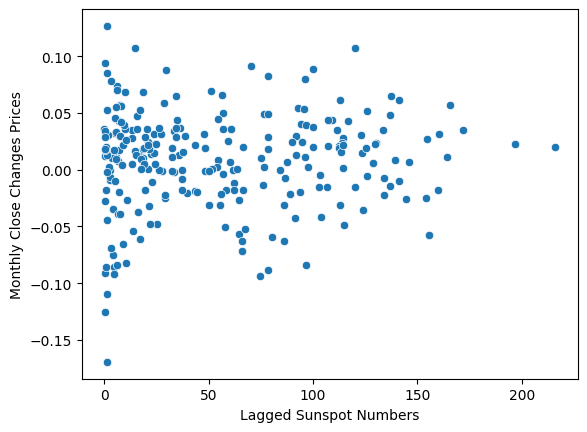

In [56]:
sns.scatterplot(data=df, x='monthly_sn_lag', y='monthly_change')
plt.xlabel('Lagged Sunspot Numbers')
plt.ylabel('Monthly Close Changes Prices')
plt.show()

This plot apparently shows no correlation…
But…

Since the SN distribution is right-skewed and includes a zero value, let’s create a new feature defined as the natural logarithm of one plus *x* (`log1p`).

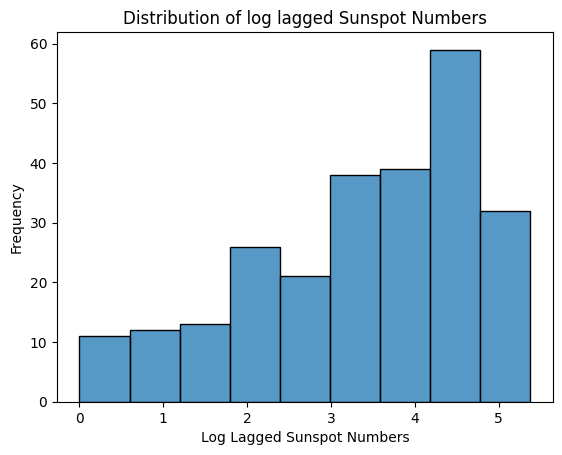

In [57]:
df['log1p_sn_lag'] = np.log1p(df['monthly_sn_lag'])

sns.histplot(data=df, x='log1p_sn_lag')
plt.title('Distribution of log lagged Sunspot Numbers')
plt.xlabel('Log Lagged Sunspot Numbers')
plt.ylabel('Frequency')
plt.show()

The right-skewed profile was "fixed". Now let's check the scatter plot.

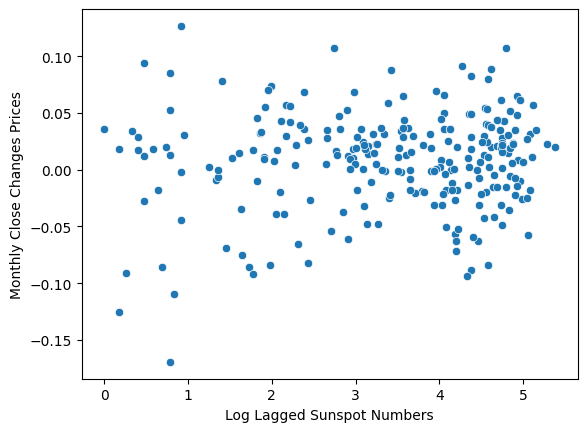

In [58]:
sns.scatterplot(data=df, x='log1p_sn_lag', y='monthly_change')
plt.xlabel('Log Lagged Sunspot Numbers')
plt.ylabel('Monthly Close Changes Prices')
plt.show()

Yet, we got a cloud of data points. Apparently we really have no correlation. But let's keep the analysis.

### **Estimation**

Let’s check the strength of the correlation between SN and S&P 500 returns.

In [59]:
print(f"The Pearson's correlation between SN and S&P 500 returns is: {df["monthly_sn_lag"].corr(df["monthly_change"])}")

The Pearson's correlation between SN and S&P 500 returns is: 0.06820708521994698


Since it is a very low correlation value, it reinforces the hypothesis of no correlation between them.

Now let's fit an OLS regression.

In [60]:
ols = smf.ols(formula='monthly_change ~ monthly_sn_lag', data=df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:         monthly_change   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.164
Date:                Fri, 19 Dec 2025   Prob (F-statistic):              0.282
Time:                        03:23:57   Log-Likelihood:                 435.44
No. Observations:                 251   AIC:                            -866.9
Df Residuals:                     249   BIC:                            -859.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0046      0.004      1.

We observe, by checking the R², that the Sunspot Number feature can explain only 0.5% of the variance in S&P 500 returns. It indicates limited explanatory power.

But we used the non-logarithmic SN; let’s try the logarithmic version.

In [61]:
ols2 = smf.ols(formula='monthly_change ~ log1p_sn_lag', data=df).fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:         monthly_change   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.027
Date:                Fri, 19 Dec 2025   Prob (F-statistic):              0.156
Time:                        03:23:57   Log-Likelihood:                 435.87
No. Observations:                 251   AIC:                            -867.7
Df Residuals:                     249   BIC:                            -860.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0018      0.007     -0.250   

We observe that the logarithmic Sunspot Number feature can explain only 0.8% of the variance in S&P 500 returns. Although it is slightly better than the previous model, it is still indicates limited explanatory power.


### **Inference**

In order to perform a more statistically robust analysis, let us evaluate the output of the fitted OLS model.

In both cases, we obtained **beta coefficient p-values** from the corresponding t-statistic tests **greater than 5%**, which implies that we **fail to reject the null hypothesis** that these coefficients are equal to zero at the 5% significance level. Therefore, the estimated betas are not statistically different from zero.

Therefore, the 95% confidence interval includes zero and economically small values, ruling out meaningful predictive power.

**This result is aligned with the previous analysis: there is no evidence that SN contains incremental information about S&P 500 returns.**

## **3. Investment Conclusion**

Based strictly on our empirical results, **we wouldn't allocate capital to this signal at Wise Capital**.

As we could observe, there is no statistical evidence of a linear correlation between SN and S&P 500 returns at the 5% significance level.

We could explore non-linear specifications. However, given the absence of any visible structure in the scatter plot and the weak signal-to-noise ratio, the expected marginal gain does not justify further model complexity.

